# Module 04 - Custom Datasets in PyTorch

We've used some datasets with pytorch before, but how do you get your own data? --> **Custom Datasets**

Depending on what you-re working on ***(vision, text, audio, recommendation)***, you should look into PyTorch domain libraries for existing data loading functions ans customizable data loading functions.

In [1]:
# Libraries

# PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Others
from pathlib import Path

# Random Seed
MY_SEED = 42

# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using Device: {device}')


Using Device: cuda


### 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 100 images per class (750 training, 250 testing)
Ourdataset starts 3 different classes of food and only 10% of the images per class (~75 training, 25 testing)

Why? When strating out ML Projects, it's important to keep things small scale to speed up training and experimentation.

In [2]:
# Libraries
import requests
import zipfile
from pathlib import Path

# Set up a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If image folder doesn's exist, downloaded and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory already exists... skipping download')

else:
    print(f'{image_path} does not axist, creating one...')
    image_path.mkdir(parents=True, exist_ok=True, )

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading Pizza, Steak and Sushi Data...')
    f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping Pizza, Steak and Sushi Data...')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping Pizza, Steak and Sushi Data...


### 2. Becoming one with the data (Data Preparation and Data Exploration)

In [3]:
import os
def walk_through_dir(dir_path):
    """Wlaks through `dir_path` returning its contents"""

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories {dirnames if len(dirnames)!=0 else ''} and {len(filenames)} images in {dirpath}.')

walk_through_dir(image_path)

There are 2 directories ['test', 'train'] and 0 images in data\pizza_steak_sushi.
There are 3 directories ['pizza', 'steak', 'sushi'] and 0 images in data\pizza_steak_sushi\test.
There are 0 directories  and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories  and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories  and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories ['pizza', 'steak', 'sushi'] and 0 images in data\pizza_steak_sushi\train.
There are 0 directories  and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories  and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories  and 72 images in data\pizza_steak_sushi\train\sushi.


In [4]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1. Visualizing Image

1. Get all the images paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using Python's `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL.
5. We'll then show the image and print metadata.

===== Random Image Metadata =====
Image Path:   data\pizza_steak_sushi\train\pizza\1412034.jpg
Image Class:  pizza
Image Height: 512 px
Image Width:  512 px


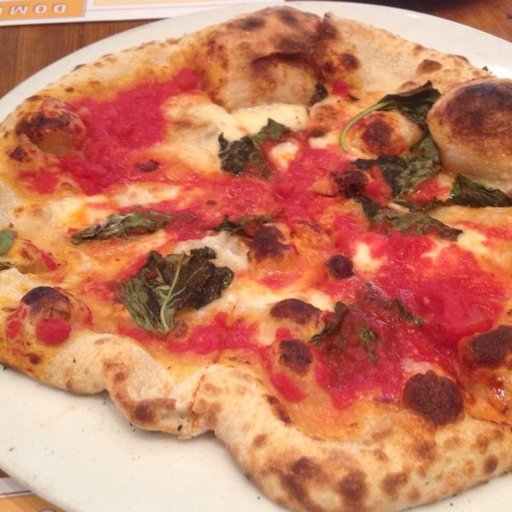

In [5]:
import random
from PIL import Image

# random.seed(MY_SEED)

# 1. Get all images path
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)
# print(f'Random Image Path:  {random_image_path}')

# 3. Det image class
image_class = random_image_path.parent.stem
# print(f'Random Image Class: {image_class}')

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print MetaData
print(f'===== Random Image Metadata =====')
print(f'Image Path:   {random_image_path}')
print(f'Image Class:  {image_class}')
print(f'Image Height: {img.height} px')
print(f'Image Width:  {img.width} px')
img

Text(0.5, 1.0, 'Image Class: pizza | Image Shape: (512, 512, 3) (HWC)')

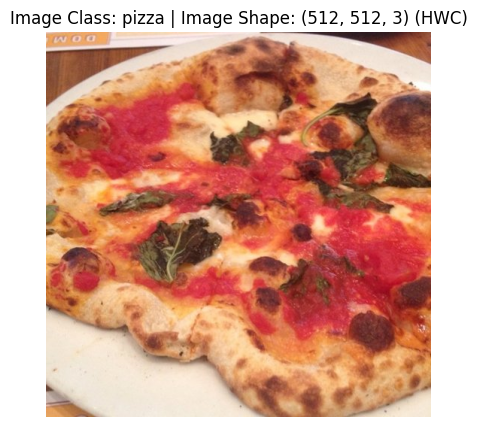

In [6]:
import matplotlib.pyplot as plt
import numpy as np

img_array = np.array(img)

plt.figure(figsize=(5,5))
plt.imshow(img_array); plt.axis(False)
plt.title(f'Image Class: {image_class} | Image Shape: {img_array.shape} (HWC)')

### 3. Transforming Data

Before we can use out image data with PyTorch:
1. Turn yout target data into tensors (in our case, numerical representation) of our images 
2. Turn it into a `torch.utils.data.Dataset` and a `torch.utils.data.DataLoader`, we'll call these  `Dataset` & `DataLoader`

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

#### 3.1. Transforming Data with `torchvision.transforms()`

In [8]:
data_transform = transforms.Compose(
    [transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()]
)

data_transform(img).shape

torch.Size([3, 64, 64])

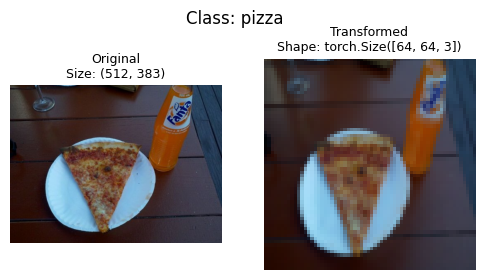

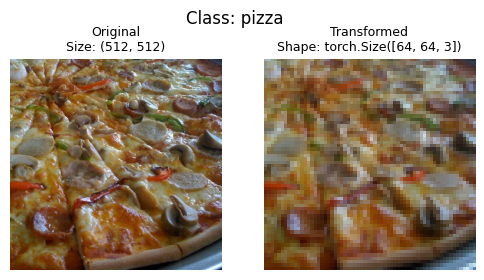

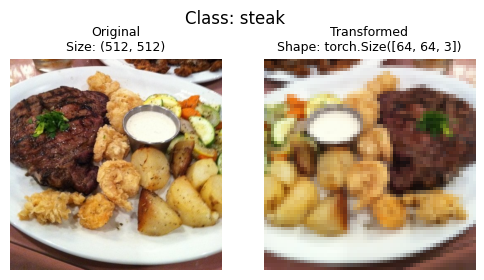

In [9]:
def plot_transformed_images(imges_paths: list, transform, n=3, seed=None):
    """ Select random images from a path of images, and load/transforms them and
    plots the original vs the transformed version."""

    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(imges_paths, k=n)

    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2, figsize=(6, 3.2))
            

            # Original
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}', fontsize=9); ax[0].axis(False)

            # Transformed
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}', fontsize=9); ax[1].axis(False)

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=12)


plot_transformed_images(image_path_list, transform=data_transform, n=3)


### 4. Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`

In [10]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
# Get Class names as a list
class_names = train_data.classes
print(f'{class_names = }')

# Classes as a dict
class_dict = train_data.class_to_idx
print(f'{class_dict = }')

print(f'{train_data.samples[0] = }')


class_names = ['pizza', 'steak', 'sushi']
class_dict = {'pizza': 0, 'steak': 1, 'sushi': 2}
train_data.samples[0] = ('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)


In [12]:
# Index the train_data toget a single image and label
img, label = train_data[0]
print(f'Image Shape: {img.shape}')
print(f'Image dtype: {img.dtype}')
print(f'Image Label: {class_names[label]}')
print(f'Label dtype: {type(label)}')

Image Shape: torch.Size([3, 64, 64])
Image dtype: torch.float32
Image Label: pizza
Label dtype: <class 'int'>


Original Shape: torch.Size([3, 64, 64])
Image Permuted: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

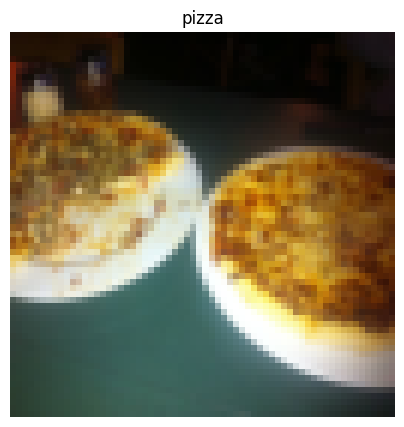

In [13]:
# Plot img
img_permuted = img.permute(1,2,0)

print(f'Original Shape: {img.shape}')
print(f'Image Permuted: {img_permuted.shape}')

# Plotting
plt.figure(figsize=(5,5))
plt.imshow(img_permuted); plt.axis(False); plt.title(class_names[label])

In [14]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 1

# Create DataLoaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f'Full Train Dataset: {len(train_data)}, Full Test Dataset: {len(test_data)} --> {BATCH_SIZE = }')
print(f'Train Dataloader:   {len(train_dataloader)}, Test Dataloader:   {len(test_dataloader)}')

Full Train Dataset: 225, Full Test Dataset: 75 --> BATCH_SIZE = 1
Train Dataloader:   225, Test Dataloader:   75


In [15]:
img, label = next(iter(train_dataloader))

print(f'Image shape: {img.shape}')
print(f'Image label: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64])
Image label: torch.Size([1])


### 5. Option 2: Loading Image Data with a Custom `Dataset`
We want to be able to:
1. Load Images from File
2. Get Class Names from the Dataset
3. Get Classes as Dictionary from the Dataset

**Pros:**
- Can create a `Dataset` out of almost anything.
- Not limited to PyTorch pre-built `Dataset` functions.

**Cons:**
- Even though you could create `Dataset` out of almost anything, it doesn-t menan it will work...
- Using a custom `Dataset` often results in us writing more code, which is more prone to errors or performance issues.

All custom datasets in PyTorch, often subclass this `torch.utils.data.Dataset`


In [16]:
# Libraries
import os
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1. Creating a helper function to get class names

We want a function to:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong)
3. Turn the class name in a dict and a list and return them.

`list(os.scandir(main_folder))` basically returns the names of the folders inside `main_folder`.

Ex: `[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]`

In [17]:
# Setup path for target directory
target_directory = train_dir
print(f'Target Dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


Target Dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [18]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [19]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""

    # 1. Get the class names from the target directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a directory of indez labels (computer prefers numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [20]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2. Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.util.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get tata from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images.
    * transform - the transform we'd like to use.
    *  classses - a list of the target classes.
    * class_toidx a dict of the target classes mapped to integer labels.
4. Create a function to `load_images`, this function will open an image.
5. Overwrite the `__len__` method to return the lenght of our dataset.
6. Overwrite the `__getitem__` method to return a given sample when passed an index.

In [21]:
# 0. Write a custom Dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initilize our custom dataset
    def __init__(self, targ_dir: str, transform=None):

        # 3. Create Class Attributes
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) # Get all image paths.
        self.transform = transform # Setup a transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""

        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite _len_()
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)
    
    # 6. Overwrite _getitem_() methos to return a particular sample
    def __getitem__(self, index: int) -> Tuple [torch.Tensor, int]:
        """Returns one samplee of data, data and label (X,y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # This expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary

        if self.transform:
            return self.transform(img), class_idx # Return transformed image and class_idx 
        return img, class_idx # Return untransformed image and class_idx

In [22]:
# Create a Transform
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [23]:
# Test out ImageFolderCustom
print(f'Train Directory: {train_dir}\nTest Directory:  {test_dir}')
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transform)
test_data_custom  = ImageFolderCustom(targ_dir=test_dir, transform=test_transform)
train_data_custom, test_data_custom

Train Directory: data\pizza_steak_sushi\train
Test Directory:  data\pizza_steak_sushi\test


(<__main__.ImageFolderCustom at 0x1f163c7cad0>,
 <__main__.ImageFolderCustom at 0x1f165fee210>)

In [24]:
print(f'train_custom_len: {len(train_data_custom)}, train_len: {len(train_data)}')
print(f'test_custom_len:  {len(test_data_custom)},  test_len:  {len(test_data)}')

train_custom_len: 225, train_len: 225
test_custom_len:  75,  test_len:  75


In [25]:
print(f'train_custom_classes: {train_data_custom.classes}, train_classes: {train_data.classes}')
print(f'test_custom_classes:  {test_data_custom.classes}, test_classes:  { test_data.classes}')

train_custom_classes: ['pizza', 'steak', 'sushi'], train_classes: ['pizza', 'steak', 'sushi']
test_custom_classes:  ['pizza', 'steak', 'sushi'], test_classes:  ['pizza', 'steak', 'sushi']


In [26]:
print(f'train_custom_classes: {train_data_custom.class_to_idx}, train_classes: {train_data.class_to_idx}')
print(f'test_custom_classes:  {test_data_custom.class_to_idx}, test_classes:  { test_data.class_to_idx}')

train_custom_classes: {'pizza': 0, 'steak': 1, 'sushi': 2}, train_classes: {'pizza': 0, 'steak': 1, 'sushi': 2}
test_custom_classes:  {'pizza': 0, 'steak': 1, 'sushi': 2}, test_classes:  {'pizza': 0, 'steak': 1, 'sushi': 2}


#### 5.3 Create a Function to display random images
1. Take in a `Dataset` and a number of other parameters such as class namess and how many images to visualize.
2. To prevent the display setting out of hand, let's cap the number of images to set at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).

In [27]:
# 1. Create a function to take in a dataset. 

def display_random_images(dataset: torch.utils.data.Dataset, classes: List[str] = None, n: int = 10,
                          display_shape: bool = True, seed: int = None):
    
    # 2. Adjuts display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be alrger than 10, setting to 10")

    # 3. Set the seed.
    if seed:
        random.seed(seed)

    # 4. get random sample indexes.
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup Plot
    plt.figure(figsize=(16,8))

    # 6. Loop
    for i, target_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # (C,H,W) to (H,W,C)

        # Plot
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust); plt.axis(False)

        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nShape: ({np.array(targ_image_adjust.shape)})'
        plt.title(title, size=10)

    

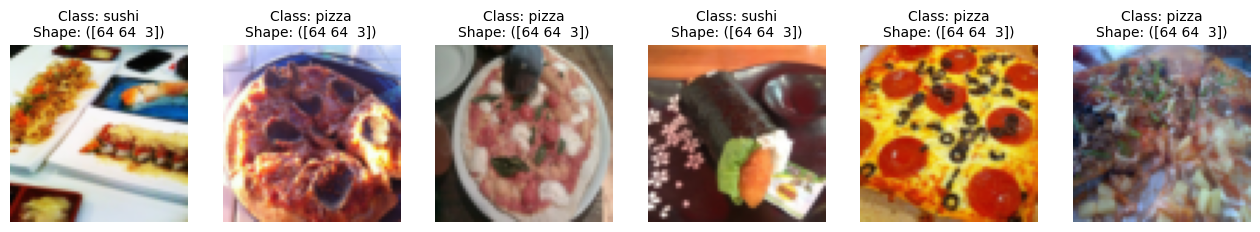

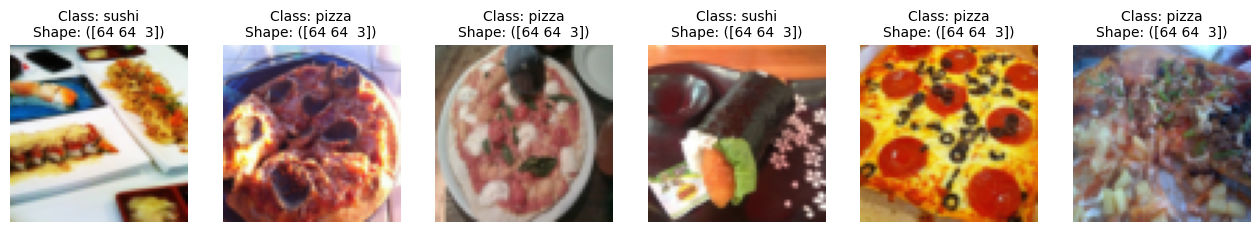

In [28]:
display_random_images(dataset=train_data, classes=train_data.classes, n=6, seed=MY_SEED)
display_random_images(dataset=train_data_custom, classes=train_data_custom.classes, n=6, seed=MY_SEED)

#### 5.4. Turn custom loaded images into **DataLoaders**

In [29]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=BATCH_SIZE, shuffle=False)

img_custom, label_custom = next(iter(train_dataloader_custom)) # See the first (X,y)
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Other forms of Transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your **Training** data.

In the case of Image data, this may mean applying various image transformation to the training images. 

**This practice hopefully results in a model thats more generalizable to unseen data**

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

In [30]:
# Let's look at TrivialAugment()
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
    ])

In [31]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

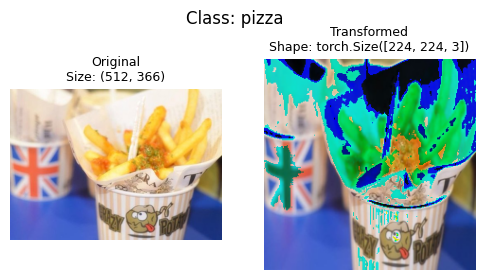

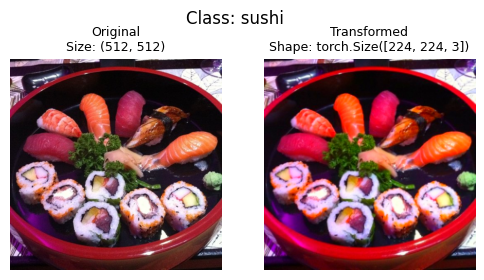

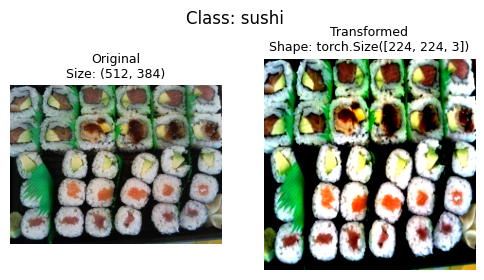

In [32]:
plot_transformed_images(imges_paths=image_path_list, transform=train_transform, n=3, seed=None)

### 7. Model 0: TinyVGG w/o data augmentation

#### 7.1. Creating transforms and loading data for Model 0

In [90]:
# Create simple transform
from torchvision import transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [91]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple  = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE,
                                     shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE,
                                     shuffle=False, num_workers=NUM_WORKERS)

#### 7.2. Create TinyVGG Model class

In [92]:
import torch.nn as nn
from torchinfo import summary
class TinyVGG(nn.Module):
    """Model architecture copying the TinyVGG from CNN Explainer."""

    def __init__(self, in_image_channeles: int, hidden_units: int, out_n_classes: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_image_channeles, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=out_n_classes)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model_0 = TinyVGG(in_image_channeles=3, hidden_units=10, out_n_classes=3).to(device)
summary(model_0, input_size=[1, 3, 64, 64])



Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### 7.3. Try a Forward pass on a single batch (to test the model)

In [93]:
%%time
image_batch, label_batch = next(iter(train_dataloader_simple))
print(image_batch.shape)
model_0.eval()
with torch.inference_mode():
    output = model_0(image_batch.to(device))

torch.Size([32, 3, 64, 64])
CPU times: total: 141 ms
Wall time: 12 s


#### 7.4. Use `torchinfo` to get an idea of the shapes going through our model

In [94]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### 7.5. Create a train and test loops functions
- `train_step()` takes in a model and a dataloader and trains the model on the dataloader.
- `test_step()` takes in a model and a dataloader and evaluates the model on the dataloader.

In [95]:
# Create train_step()
from tqdm.auto import tqdm
def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader,
               criterion: nn.Module, optimizer: torch.optim.Optimizer):
    
    model.train()

    # Setup train loss and accuracy values
    epoch_loss, epoch_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        output = model(X); y_probs = torch.softmax(output, dim=1); preds = y_probs.argmax(dim=1)
        loss = criterion(output, y); epoch_acc +=  (preds == y).sum().item()/len(preds)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss /= len(dataloader)
    epoch_acc /= len(dataloader)

    return epoch_loss, epoch_acc

def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader,
              criterion: nn.Module, device=device):
    model.eval()

    test_epoch_loss, test_epoch_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_outputs = model(X); test_probs = torch.softmax(test_outputs, dim=1); test_preds = test_probs.argmax(dim=1)
            test_epoch_loss += criterion(test_outputs, y).item(); test_epoch_acc += (test_preds == y).sum().item()/len(test_preds)
        test_epoch_loss /= len(dataloader)
        test_epoch_acc /= len(dataloader) 
    return test_epoch_loss, test_epoch_acc

def train_model(model: nn.Module, training_dataloader: torch.utils.data.DataLoader, 
                testing_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.Module = nn.CrossEntropyLoss(), 
                n_epochs: int = 5, device=device):
    
    """Trains a model during `n_epochs`"""
   
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    
    for epoch in tqdm(range(n_epochs)):

        epoch_loss, epoch_acc = train_step(model=model, dataloader=training_dataloader, criterion=criterion, optimizer=optimizer)
        test_epoch_loss, test_epoch_acc = test_step(model=model, dataloader=testing_dataloader, criterion=criterion, device=device)

        results['train_loss'].append(epoch_loss); results['train_acc'].append(epoch_acc); 
        results['test_loss'].append(test_epoch_loss); results['test_acc'].append(test_epoch_acc); 

        if (epoch % max(1, n_epochs // 10) == 0):
            print(f'Epoch: {epoch:4}, Train_Loss: {epoch_loss:.4f} | Train_Acc: {epoch_acc:.4f}, Test_Loss: {test_epoch_loss:.4f} | Test_Acc: {test_epoch_acc:.4f}')
    print(f'Epoch: {epoch:4}, Train_Loss: {epoch_loss:.4f} | Train_Acc: {epoch_acc:.4f}, Test_Loss: {test_epoch_loss:.4f} | Test_Acc: {test_epoch_acc:.4f}')

    return results


In [96]:
# Libraries
from timeit import default_timer as timer

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(in_image_channeles=3, hidden_units=10, out_n_classes=3).to(device)

# Define Loss Fn and Optimizer
criterion_0 = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer()
model_0_results = train_model(model=model_0, training_dataloader=train_dataloader_simple, testing_dataloader=test_dataloader_simple,
            optimizer=optimizer_0, criterion=criterion_0, n_epochs=NUM_EPOCHS, device=device)
stop_time = timer()

print(f'Total Training Time: {(stop_time-start_time):.4f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:    0, Train_Loss: 1.1063 | Train_Acc: 0.3047, Test_Loss: 1.0983 | Test_Acc: 0.3011
Epoch:    1, Train_Loss: 1.0998 | Train_Acc: 0.3281, Test_Loss: 1.0697 | Test_Acc: 0.5417
Epoch:    2, Train_Loss: 1.0869 | Train_Acc: 0.4883, Test_Loss: 1.0807 | Test_Acc: 0.4924
Epoch:    3, Train_Loss: 1.0846 | Train_Acc: 0.4023, Test_Loss: 1.0607 | Test_Acc: 0.5833
Epoch:    4, Train_Loss: 1.0664 | Train_Acc: 0.4180, Test_Loss: 1.0659 | Test_Acc: 0.5644
Epoch:    4, Train_Loss: 1.0664 | Train_Acc: 0.4180, Test_Loss: 1.0659 | Test_Acc: 0.5644
Total Training Time: 129.9543 seconds


#### 7.8. Plot the Loss Curves of Model 0

A **loss curve** is a way of tracking your model's progress over time (epochs).

In [97]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

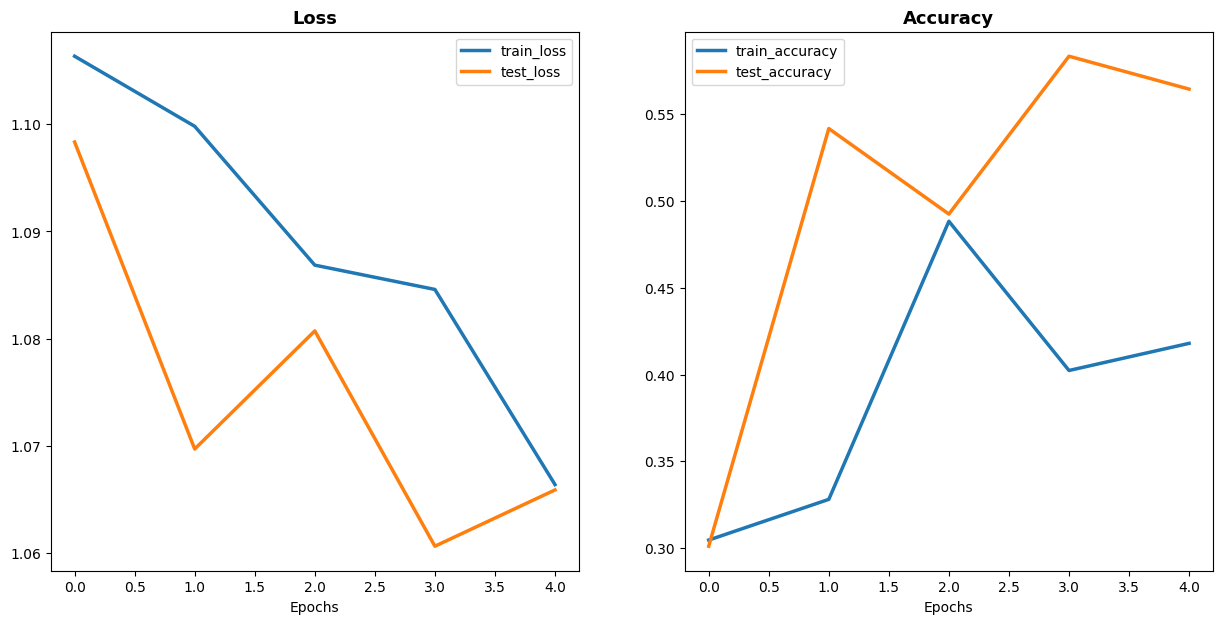

In [98]:
def plot_loss_curves(results: Dict[str, List[float]]):

    """Plots training curves of a results dictionary"""

    TITLE_SIZE=13

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, linewidth=2.5, label='train_loss')
    plt.plot(epochs, test_loss, linewidth=2.5, label='test_loss')
    plt.title('Loss', size=TITLE_SIZE, weight= 'bold'); plt.xlabel('Epochs'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, linewidth=2.5, label='train_accuracy')
    plt.plot(epochs, test_accuracy, linewidth=2.5, label='test_accuracy')
    plt.title('Accuracy', size=TITLE_SIZE, weight= 'bold'); plt.xlabel('Epochs'); plt.legend()

plot_loss_curves(model_0_results)


### 8. What should an ideal loss curve look like?

They give us information about our model to identify if it is **underfitting** or **overfitting**.

### 9. Model 1: TinyVGG with Data Augmentation

#### 9.1. Create transform with data augmentation

In [99]:
# Create training transform with TrivvivalAugment

from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#### 9.2. Create train and test `Dataset`'s and `DataLoaders`'s with data agmentation

In [100]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)
test_data_augmented  = datasets.ImageFolder(root=test_dir,  transform=test_transform_trivial)

In [101]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(MY_SEED); torch.cuda.manual_seed(MY_SEED)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [102]:
len(train_data_augmented.classes)

3

#### 9.3. Create an Instance of Model 1
Same arquitechture but different data (augmentation)

In [103]:
# Create Model 1 and send it to device
torch.manual_seed(MY_SEED); torch.cuda.manual_seed(MY_SEED)
model_1 = TinyVGG(in_image_channeles=3, hidden_units=10, out_n_classes=len(train_data_augmented.classes)).to(device)

summary(model=model_1)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      5,073
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0

In [104]:
# Create Criterion and Optimizer
torch.manual_seed(MY_SEED); torch.cuda.manual_seed(MY_SEED)

NUM_EPOCHS = 5

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train Model 1
model_1_results = train_model(model=model_1, training_dataloader=train_dataloader_augmented, 
                              testing_dataloader=test_dataloader_augmented, optimizer=optimizer_1,
                              criterion=criterion_1, n_epochs=NUM_EPOCHS, device=device)


stop_time = timer()

print(f'Total Training Time: {(stop_time-start_time):.4f} seconds')


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:    0, Train_Loss: 1.1045 | Train_Acc: 0.2500, Test_Loss: 1.1016 | Test_Acc: 0.2604
Epoch:    1, Train_Loss: 1.0761 | Train_Acc: 0.4258, Test_Loss: 1.1315 | Test_Acc: 0.2604
Epoch:    2, Train_Loss: 1.0731 | Train_Acc: 0.4258, Test_Loss: 1.1702 | Test_Acc: 0.2604
Epoch:    3, Train_Loss: 1.1223 | Train_Acc: 0.3047, Test_Loss: 1.1543 | Test_Acc: 0.2604
Epoch:    4, Train_Loss: 1.0734 | Train_Acc: 0.4531, Test_Loss: 1.1495 | Test_Acc: 0.3021
Epoch:    4, Train_Loss: 1.0734 | Train_Acc: 0.4531, Test_Loss: 1.1495 | Test_Acc: 0.3021
Total Training Time: 130.6208 seconds


#### 9.4. Plot the loss curves of model 1

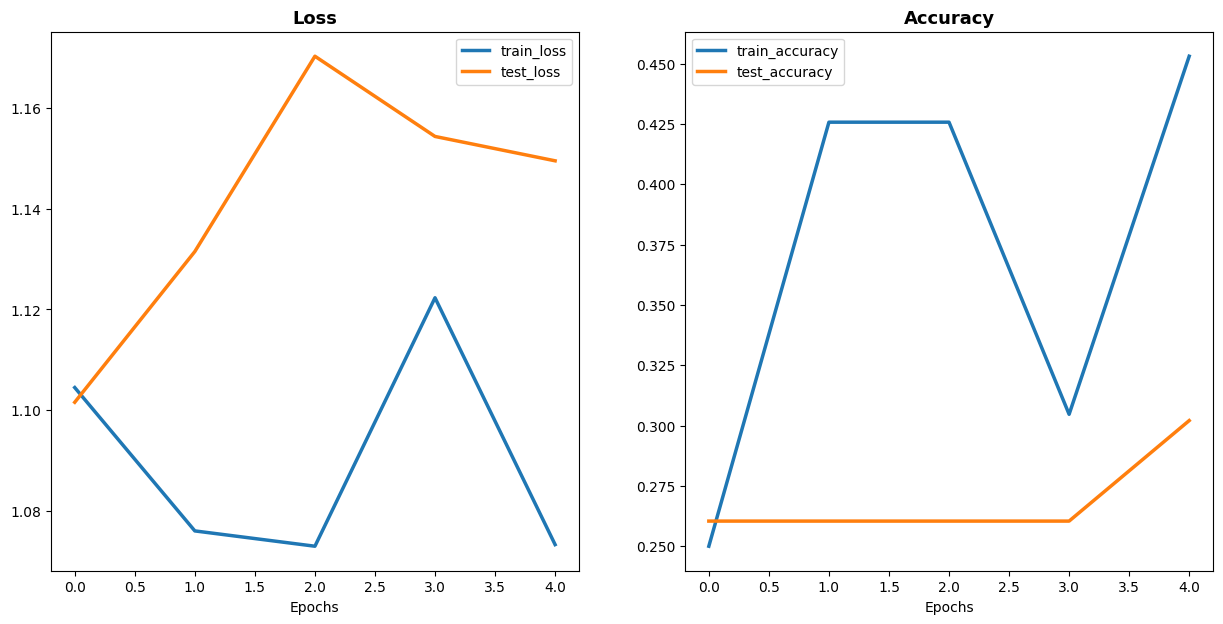

In [105]:
plot_loss_curves(results=model_1_results)

### 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different  ways to do this:
- Hard Coding (what we're doing)
- PyTorch + Tensorboard
- Weight & Biases
- MLFlow

In [106]:
import pandas
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df 

,train_loss,train_acc,test_loss,test_acc
0,1.106324,0.304688,1.098328,0.301136
1,1.099793,0.328125,1.069724,0.541667
2,1.086857,0.488281,1.080729,0.492424
3,1.084592,0.402344,1.060666,0.583333
4,1.066410,0.417969,1.065910,0.564394


Text(0.5, 0, 'Epochs')

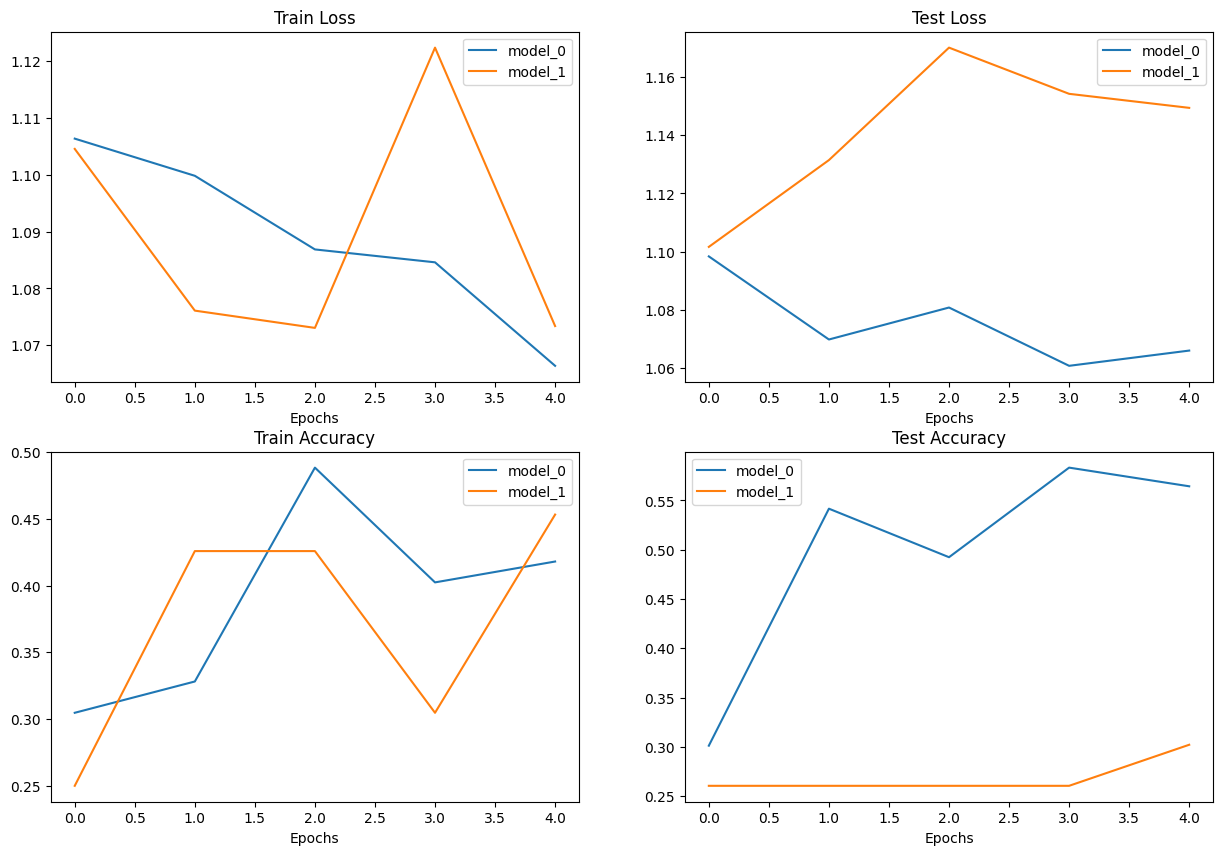

In [113]:
# Setup a plot
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='model_0')
plt.plot(epochs, model_1_df['train_loss'], label='model_1')
plt.title('Train Loss'); plt.legend(); plt.xlabel('Epochs')

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='model_0')
plt.plot(epochs, model_1_df['test_loss'], label='model_1')
plt.title('Test Loss'); plt.legend(); plt.xlabel('Epochs')

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='model_0')
plt.plot(epochs, model_1_df['train_acc'], label='model_1')
plt.title('Train Accuracy'); plt.legend(); plt.xlabel('Epochs')

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='model_0')
plt.plot(epochs, model_1_df['test_acc'], label='model_1')
plt.title('Test Accuracy'); plt.legend(); plt.xlabel('Epochs')

### 11. Own image

In [114]:
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg')
        print(f'Downloading {custom_image_path}...')
        f.write(request.content)
else:
    print(f'{custom_image_path} already exists, skipping download...')

#### 11.1. Loading in a custom image with PyTorch
We have to make sure our image is in the same format as the data our model was trained on.

- In tensor form with datatype (torch.float32)
- Shape `[1x3x64x64]`: `[batch x channels x heigth x width]`
- Same device

In [120]:
import torchvision
# Read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom Image Shape: {custom_image_unit8.shape}')
print(f'Custom Image dtype: {custom_image_unit8.dtype}')

Custom Image Shape: torch.Size([3, 4032, 3024])
Custom Image dtype: torch.uint8


In [131]:
# Read in custom image with correct data type
import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
print(f'Custom Image Shape: {custom_image.shape}')
print(f'Custom Image dtype: {custom_image.dtype}')

Custom Image Shape: torch.Size([3, 4032, 3024])
Custom Image dtype: torch.float32


In [140]:
# Correcting image shape (Resize)
from torchvision import transforms

custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])
custom_image_reshaped = custom_image_transform(custom_image)
custom_image_reshaped_unsq = custom_image_reshaped.unsqueeze(dim=0)

print(f'Custom Image Shape: {custom_image_reshaped_unsq.shape}')
print(f'Custom Image dtype: {custom_image_reshaped_unsq.dtype}')


Custom Image Shape: torch.Size([1, 3, 64, 64])
Custom Image dtype: torch.float32


Text(0.5, 1.0, 'Predicted: pizza')

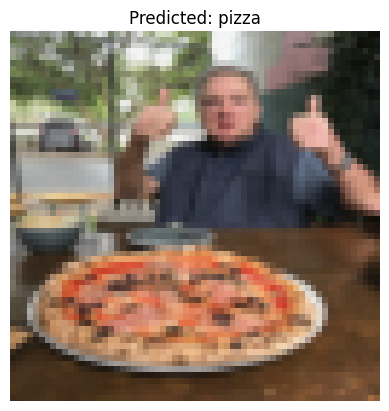

In [150]:
# Try to make a prediction on an image in unit8 format
model_1.eval()
with torch.inference_mode():
    custom_image_output = model_1(custom_image_reshaped_unsq.to(device))
    custom_image_probs = torch.softmax(custom_image_output, dim=1)
    custom_image_preds = custom_image_probs.argmax(dim=1).item()
plt.imshow(custom_image_reshaped.permute(1,2,0)); plt.axis(False); 
title = class_names[custom_image_preds]
plt.title(f'Predicted: {title}')


Note, to make a prediction on acustom image, we had to:
- Load the image and turn it into a `Tensor`.
- Make sure images have same `datatype`
- Make sure images have same `shape`
- Make sure images are in same `device`  

#### 11.2. Putting custom image prediction together: Building a Function

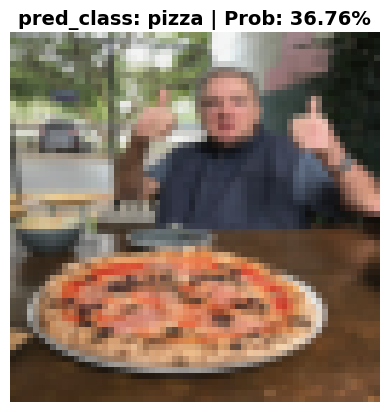

In [190]:
def pred_and_plot_image(model: nn.Module, image_path: str, class_names: List[str] = None,
                        transform = None, device=device):
    """Makes a prediction ona  target image with a trained model and plots the image and prediction"""

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) # Import image
    target_image = target_image/255. # Scale
    target_image = target_image.unsqueeze(dim=0)
    

    if transform:
        target_image = transform(target_image)
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        output = model(target_image.to(device))
        prob = torch.softmax(output, dim=1)
        pred = prob.argmax(dim=1)
    
    plt.imshow(target_image.squeeze(dim=0).permute(1,2,0)); plt.axis(False)

    if class_names:
        title = f'pred_class: {class_names[pred.cpu()]} | Prob: {prob.max().cpu():.2%}'
    else: 
        title = f'pred_class: {pred.cpu().item()} | Prob: {prob.max().cpu():.2%}'
    plt.title(title, size=14, weight='bold')

pred_and_plot_image(model=model_1, image_path=custom_image_path, transform=custom_image_transform, class_names=class_names, device=device)
